# seq2seq with TensorFlow

seq2seq网络架构:
![seq2seq 网络架构](pictures/1-seq2seq.png)
Encoder 获得输入 `[A, B, C]` . 我们不关心encoder的输出是什么, 只需要得到它最后的隐含状态就可以了，将它传递给decoder端, 输入为 `[<EOS>, W, X, Y, Z]` 训练的目标为 `[W, X, Y, Z, <EOS>]`. 

## Vocabulary

如果是文本数据，则需要首先建立词库表，就是把词和对应的ID做好映射

In [1]:
x = [[5, 7, 8], [6, 3], [3], [1]]

In [2]:
import helpers
xt, xlen = helpers.batch(x)

In [3]:
x

[[5, 7, 8], [6, 3], [3], [1]]

In [4]:
xt

array([[5, 6, 3, 1],
       [7, 3, 0, 0],
       [8, 0, 0, 0]])

In [5]:
xlen

[3, 2, 1, 1]

# Building a model

In [6]:
import numpy as np
import tensorflow as tf
import helpers

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [8]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units

- `encoder_inputs` int32 tensor is shaped `[encoder_max_time, batch_size]`
- `decoder_targets` int32 tensor is shaped `[decoder_max_time, batch_size]`

In [9]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

- `decoder_inputs` int32 tensor is shaped `[decoder_max_time, batch_size]`

In [10]:
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')

## Embeddings


In [11]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

In [12]:
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

## Encoder


In [13]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_embedded,
    dtype=tf.float32, time_major=True,
)

del encoder_outputs

In [14]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 20) dtype=float32>)

## Decoder

In [15]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_embedded,

    initial_state=encoder_final_state,

    dtype=tf.float32, time_major=True, scope="plain_decoder",
)

In [16]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)

decoder_prediction = tf.argmax(decoder_logits, 2)

### Optimizer

In [17]:
decoder_logits

<tf.Tensor 'fully_connected/BiasAdd:0' shape=(?, ?, 10) dtype=float32>

In [18]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [19]:
sess.run(tf.global_variables_initializer())

## Training 

In [22]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[5, 5, 7, 8, 8]
[7, 3, 3]
[3, 3, 2, 3]
[3, 4, 7, 5, 9, 2]
[4, 9, 7, 8, 6, 5, 6]
[7, 6, 2]
[2, 9, 2, 7, 9, 5]
[5, 7, 2, 8, 6, 2, 9]
[9, 4, 9, 4, 4, 7]
[5, 2, 7]


In [23]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, _ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, _ = helpers.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

输入 `[5, 6, 7]`, decoder_targets `[5, 6, 7, 1]`,  其中 1 代表 `EOS`, decoder_inputs `[1, 5, 6, 7]`

In [24]:
loss_track = []

In [25]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.3390607833862305
  sample 1:
    input     > [3 6 9 5 6 4 2 6]
    predicted > [6 5 8 9 9 8 9 9 8]
  sample 2:
    input     > [4 2 6 6 5 0 0 0]
    predicted > [6 7 7 7 7 8 9 9 9]
  sample 3:
    input     > [3 8 9 6 9 4 8 5]
    predicted > [6 3 3 9 3 9 3 3 9]

batch 1000
  minibatch loss: 0.30939382314682007
  sample 1:
    input     > [9 5 9 9 7 2 0 0]
    predicted > [9 9 9 9 7 2 1 0 0]
  sample 2:
    input     > [9 3 7 7 4 9 0 0]
    predicted > [9 3 7 7 4 9 1 0 0]
  sample 3:
    input     > [7 7 2 4 2 7 5 0]
    predicted > [7 7 2 4 2 7 5 1 0]

batch 2000
  minibatch loss: 0.15077874064445496
  sample 1:
    input     > [5 7 2 4 3 8 0 0]
    predicted > [5 7 2 4 3 8 1 0 0]
  sample 2:
    input     > [4 8 4 6 3 6 7 7]
    predicted > [4 8 4 6 7 7 7 7 1]
  sample 3:
    input     > [4 9 4 0 0 0 0 0]
    predicted > [4 9 4 1 0 0 0 0 0]

batch 3000
  minibatch loss: 0.09187103807926178
  sample 1:
    input     > [3 9 3 0 0 0 0 0]
    predicted > [3 9 

loss 0.1038 after 300100 examples (batch_size=100)


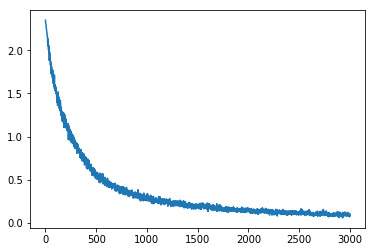

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))